# Lab 1: Furuta pendulum measurements and actuation
## Background
In this series of 3 labs we will control the Furuta pendulum pictured below to swing up its arm and balance it in the upright position.

![Furuta Pendulum](img/lab1-furuta.png)

Much of machine learning concerns fitting a function to data. An artificial neural network (ANN) is for example a mapping from a an input vector $u$ to an output vector $y$, and can be represented by a (complicated) ordinary function $f:u\to y$. In an ANN, $f$ is parameterized as a matrix of weights $W$. When the network is trained, the values of weights are adjusted to obtain $f(u;W)\approx y$ for known data $(u,y)$. A strength of ANNs is that they are very flexible, meaning that they can approximate rather arbitrary mappings. This is also the reason that cross validation is so important to detect over-fitting of data. Particularly, the flexibity of $f$ becomes problematic if the training data is not sufficiently informative. This can be resolved by gathering additional training data. Sometimes this is expensive or even impossible. It is therefore always good to use as much prior knowledge as possible when modelling.

The pendulum has a scalar (single-valued) real input $u$, that somehow relates to the angular velocity of its base, $\dot{\varphi}$. (The dot is convenient way to denote differentiation with respect to time, for example $\dot{x}=dx/dt$). We will shortly take a closer look at properties of this input. The pendulum also provides two measurements: the base angle $\varphi$ and the arm angle $\theta$. We will take a closer look at them too.

Being aspiring machine learning experts, we could now train a neural network to represent the mapping from the input $u$ to the output $y=[\varphi~\theta]$. This raises a number of questions:

1. How shall we choose the training input u, in order to cover the feature space that we are interested to model?

2. What is a good way to validate the model we obtain?

3. How can we use the obtained ANN to get closer to our goal of controlling the Furuta pendulum?

As we will see in this and the next lab, the Furuta pendulum has properties that enable us to restrict the search for a model to a much narrower class of mapping than ANNs provide, and this will prove useful when approaching the questions above. Incorporating knowledge of such properties into machine learning models is a recent research topic, and in order to get you on board, we will here focus on getting you familiar with "classical" modeling and control of dynamical systems, that is a pre-requisite for such composite models.

In this first lab, the focus will lie on getting familiar with the Julia programming language, and getting started with experimenting on the physical Furuta pendulum. We will write functions for measuring angles and estimating angular velocies. Finally, we will develop a very simple model for the actuating DC motor. Lab 2 will focus on modelling and simulation, and in Lab 3 we will control the pendulum in the upright position, and also implement and energy-based conrol law that swings it up from its resting position.

The labs are all quite open-ended and exploratory. It is strongly encouraged that you experiment outside the boundaries of their manuals, and that you actively seek knowledge online and by interacting with the instructors.

**To pass the lab fill all cells marked "A" with text or code, and be ready to discuss the content of the lab in a small group during the examination session.**

## Getting started
First, let us load some code packages into the Julia environment:

In [1]:
using FurutaPendulums, Plots, DelimitedFiles, ControlSystems

The FurutaPendulums package defines an interface between Julia and the physical process. To instantiate a pendulum we do 

In [2]:
furuta = FurutaPendulum()

FurutaPendulum()

We can now send an input command to the Furuta pendulum:

In [6]:
u=2.0
control(furuta,u)

2.0

The pendulum should start spinning, and will stop after a while (5 seconds) due to a built in time-out. Without the timeout it would spin forever, or at least until it received a control command that stopped it.

At some point during the labs you will likely also see the pendulum move fast, then suddenly stop. This is most likely due to a built-in energy threashold, that cuts actuation of the motor if the kinetic energy of the the moving parts gets too high. This mechanism is in place to protect you and the equipment. It should not pose a problem during normal operation.

Next, let us define a control signal trajectory:

In [7]:
h=1.0 # This is the update period (often called sampling), in seconds
last_time=periodic_wait(furuta,0.0,0.0)
for k=1:5
    if iseven(k)
        u=2.5
    else
        u=0.0
    end
    control(furuta,u)
    last_time=periodic_wait(furuta,last_time,h)
end

Let us digest the code block above. First we declare a period `h` that tells us for how many seconds at a time (the sampling period) the input `u` should be held constant. Then we declare a start time. To see the numeric value of this time, type:

In [6]:
@show periodic_wait(furuta,0.0,0.0)

periodic_wait(furuta, 0.0, 0.0) = 1.663937227338542e9


1.663937227338542e9

The large number is the number of seconds since the beginning of 1970, also known as the UNIX epoch. Subsequent calls of ```periodic_wait``` will tell the function to wait on the ```furuta``` object until ```h```seconds has passed since the time stored in ```last_time```.

Then there is a ```for``` loop that runs for each integer value in the range ```k=1:5```

Q: What happens in the body of the `for` loop? (Type your answer in the answer cell below.)

A: (Write your answer here)

Q: Now write and execute an experiment of 3 s duration, where the input signal is $u(t)=2.5 \sin(3.0t)$ and the sampling period is 0.01 s.

In [7]:
#A:(Write your code in this cell)

## Angle measurements
In the experiments above, we can see that the pendulum device is moving. But to get a model, we will need some quantified measurements. The code below actuates the device and meausures the base angle $\varphi$. Take a close look and make sure you understand what it does.

In [11]:
h=0.01 # 10 ms
start_time=last_time=periodic_wait(furuta,0.0,0.0)

φ_raws=Float64[] # Array for storing measurements
ts=Float64[]

u=2.5

for k=1:round(5/h)
    control(furuta,u)
    last_time=periodic_wait(furuta,last_time,h)
    φ_raw=read(furuta.arm_angle)
    φ_raws=[φ_raws; φ_raw]
    ts=[ts; last_time-start_time] 
end
control(furuta,0.0) # It stops after 5 seconds, but we might as well stop it when we are done

-0.00015259021896696368

The measurement of $\varphi$ is obtained from a rotary encoder, providing a counter that increments (or decrements, depending on the direction of rotation) its value at evenly spaced angular intervals. The resolution of a rotary encoder is the number of such increments per full revolution. Let us plot the base angle as a function of time:

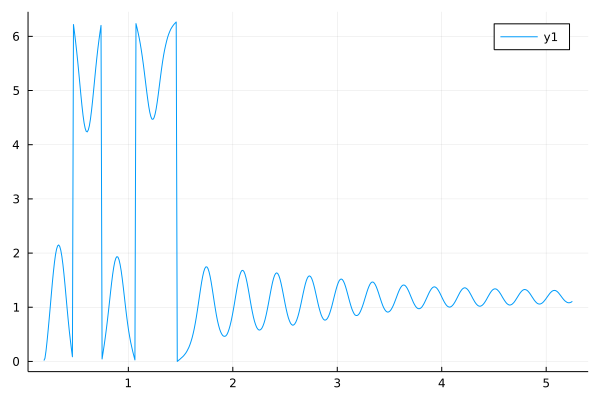

In [13]:
plot(ts, φ_raws)

Q: Can you tell from the figure how many full revolutions the base underwent during the experiment? And what approximately is the resolution of the base encoder?

A: 

Q: Next compute the resolution of the encoder directly from the array `φ_raws`. 

In [14]:
# A:
resolution = 360/(maximum(φ_raws)-minimum(φ_raws))
# Hint: check out the functions minimum/maximum

0.018029749085991885

Q: The encoder uses a number of bits to store its value. Based on the resolution above, how many bits would you assume the encoder uses?

In [ ]:
# A: 16 bits
# Hint: The 2-logaritm is called log2 in Julia

Q: Another thing that you might already have noticed in the figure above is that the encoder does not always cycle (jump) to 0, but rather at some varying small values. Can you explain this? Hint: Try to run the encoder experiment with some different sample periods, both smaller and larger than the nominal `h=0.01` and observe how the quantization effects change.

A: because the sampling period is not short enough, so the angle value comes to 0 in the interval of two samplings, and for the nwxt sampling it goes a little higher.

One conclusion from the recent experiment should be that as long as the sampling is fast and the encoder resolution is high, it is fair to approximate the encoder signal as being real rather than integer-valued. Ensuring these conditions, we can then obtain an angle in radians through dividing `φ_raws` by the resolution and multiplying by $2\pi$. This is particularly useful since different hardware versions of the pendulums use encoders of different resolutions. To access angles in radians, we can use:

In [16]:
@show read(furuta.base_angle); # Here we use @show to get 2 printouts from the same code cell
@show read(furuta.arm_angle);

read(furuta.base_angle) = 5.8837871824216075
read(furuta.arm_angle) = 0.006519325551232166


Re-run the base spinning experiment using the angle instead, `read(furuta.base_angle)`, and verify that it behaves as you would expect it to.

Q: Someone argues that the relation between the control signal $u$ and the measurement signal $y=[\varphi~\theta]^\top$ is static, rather than dynamic. Explain the difference and plot the results of an experiment that you can use to show that the relation is in fact dynamic.


A:

In [ ]:
# A: (experiment and plot)

## Angular velocity estimates
The fact that $y$ and $u$ relate dynamically means that it is not sufficient to know $u(t)$ for times $t\geq 0$ to uniquely determine $y$, and it is likely some variant of this that you have used in your answer above.

However, we will see in lab 2 that the dynamics can be expressed on state space form as
$$
\begin{align}
\dot{x} &= f(x,u),\\
y &= g(x),
\end{align}
$$
where $x$ is a vector representing the (internal) state of the system.

Certainly, the evolution of $y(t)$ will differ depending on the vales of $\varphi(0)$ and $\theta(0)$. But these two elements are not alone sufficient to capture the state of the pendulum. For instance, the evolution of the base angle $\varphi$ with $u=0$ will differ depending on if the experiment starts with the base in stationarity ($\dot{\varphi}=0$) or in rotation ($\dot{\varphi}\neq 0$). So at least we need to add $\dot{\varphi}$ and $\dot{\theta}$ as elements to our state vector:

$$
x=
\begin{bmatrix}
\varphi\\
\dot{\varphi}\\
\theta\\
\dot{\theta}
\end{bmatrix}
$$

Later, we will see that these four variables are not only necessary, but also sufficient for describing the basic dynamics of the pendulum.

But the encoders only give us $\varphi$ and $\theta$. How can we measure their time derivatives? The answer is: we cannot. 
There are sensors for measuring angles or angular accelerations, but none for *directly* measuring (angular) velocity. 
Angular velocities instead need to be computed as estimates based on measurements from one of the existing sensors. In our case, we can use the angle measurements as a basis for estimating angular velocitites.

The definition of the derivative inspires a simple way to estimate $\dot{\varphi}$:

$$
\dot{\varphi}(t)=\frac{d\varphi(t)}{dt}=\lim_{h\to 0}\frac{\varphi(t)-\varphi(t-h)}{h}.
$$

Instead of taking the limit $h\to 0$ we use a finite but small value. In our case the smallest possible value is the time between two consecutive samples, that we have conveniently already denoted by `h`.

Q: Write code that records $\varphi$, $\theta$ and the corresponding sampling times into vectors. For this you can use `read(furuta.base_angle)` and `read(furuta.arm_angle)`, as we have already done . Then compute and plot finite-difference estimates $\dot{\varphi}$ and $\dot{\theta}$ from the recorded values. Be careful to handle the discontinuety that occurs once per full revolution of $\varphi$ and $\theta$, respectively.

In [5]:
h=0.01 # 10 ms
start_time=last_time=periodic_wait(furuta,0.0,0.0)

φ_raws=Float64[] # Array for storing measurements
θ_raws=Float64[]
ts=Float64[]
c= 0 
φdot = Float64[]
θdot = Float64[]

u=2.5

for k=1:round(5/h)
    control(furuta,u)
    last_time=periodic_wait(furuta,last_time,h)
    φ_raw=read(furuta.base_angle)
    θ_raw=read(furuta.arm_angle)
    c=c+1
    if k > 1 && φ_raw > φ_raws[c-1]
        φdot = [φdot; (φ_raw - φ_raws[c-1])/h]
    end
    if k > 1 && (abs(θ_raw - θ_raws[c-1])<2)
        θdot = [θdot; (θ_raw - θ_raws[c-1])/h]
    end
    
    φ_raws=[φ_raws; φ_raw]
    θ_raws=[θ_raws; θ_raw]
    ts=[ts; last_time-start_time] 
end
control(furuta,0.0) # It stops after 5 seconds, but we might as well stop it when we are done

(θdot,φdot)

([4.112927443350881, 12.415480277714199, 16.93107194628824, 19.385406271458, 20.957714198519884, 21.973962005035474, 22.30951552605479, 22.07942168307011, 20.507113756008245, 18.014430457007702  …  2.281763942931292, 2.396810864423582, 2.5310322728312684, 2.2721766994735937, 2.118780804150422, 1.7352910658426701, 1.3230395971618236, 0.8916136415655807, 0.2972045471885565, -0.17257038223847943], [4.841557946135655, 14.016549935149136, 20.67968413824674, 21.83015335317006, 22.146532387273975, 22.242404821850926, 22.462911421377886, 22.654656290531783, 22.903924620431827, 23.153192950331892  …  24.063981078812844, 24.102330052643637, 24.246138704509022, 24.0064576180667, 24.18861524376288, 24.18861524376288, 23.977695887693606, 24.18861524376288, 24.006457618066612, 23.872236209659015])

If we want to control the pendulum, we need access to estimates of $\dot{\varphi}$ and $\dot{\theta}$ on-the-fly. To get this, we can store the latest values read using `read(furuta.base_angle)` and `read(furuta.arm_angle)` and the corresponding time stamps into variables.

Q: Write a function `measure(furuta, prev_state, h)` that returns the state as a tuple `(φ,φdot,θ,θdot)`, where the derivatives are finite difference approximations. The `furuta` is used for measuring the new angles, and the new angular velocities can be calculated similar to above, using the new and previous angles and the sampling time. Think about how to handle the first call to the function.

In [7]:
φdot


480-element Vector{Float64}:
  4.841557946135655
 14.016549935149136
 20.67968413824674
 21.83015335317006
 22.146532387273975
 22.242404821850926
 22.462911421377886
 22.654656290531783
 22.903924620431827
 23.153192950331892
 23.536682688639665
 23.68049134050505
 24.131091783016732
  ⋮
 24.063981078812844
 23.939346913862856
 24.063981078812844
 24.102330052643637
 24.246138704509022
 24.0064576180667
 24.18861524376288
 24.18861524376288
 23.977695887693606
 24.18861524376288
 24.006457618066612
 23.872236209659015

We can now measure the configuration (angles) of the pendulum, and we have a very simple means of estimating the corresponding angular velocities, all built into the `measure` command. Next, we will investigate how the control signal affects the pendulum.

## A little bit about DC motors
The pendulum base is actuated by a permanent magnet brushless DC motor. Such motors are found in an abundance of application. Permanent magnet DC motors have a number of magnets configured on the rotor (the part that rotates) and a number of coils configured on the stator (the stationary part). The photo below shows what they look like on the inside.

![Stator coils](img/lab1-coils.jpeg)

The coils and magnets are grouped in groups of 3, making the motor electrically equivalent to the circuit diagram below.

![3 phase BLDC motor](img/lab1-3phase.png)

The little switches are transistors, and by closing or opening them each phase of the motor can be exposed to either of the voltages $u_{\min}$, $u_{\max}$, or it can be left unconnected. Commutating the motor is the act of opening and closing these switches based on the relative position of the stator and the rotor. In a brushed DC motor, this is done automatically by brushes that gain and lose contact as the rotor rotates. In a brushless motor, commutation is instead done in software. This software is part of the firmware of the physical furuta pendulum unit. (Another essential part of the firmware handles communicaton with the PC, making it possible for us to issue control signals and read measurements from the device.)

The role of the commutation firmware is to ensure that the right combination of switches are closed for the desired flux interactions between the permanent magnets and the magnetic field arising from running current through the phases. Typically (and indeed here) the desired flux interaction is the one that produces a driving torque, but it could also for instance be desired to commutate the motor such that the rotor is locked relative to the stator.

Assuming the commutation switching is correctly handled (the firmware does it for us), the torque between the rotor and stator is proportional to the current drawn by the motor phases. A type of pulse width modulation (PWM) is used to control the phase currents. PWM is a very common technique for turning a binary control signal into an analog one by executing a periodic task where t$u=u_{\max}$ for a fixed fraction $\alpha$ of the period and $u=_{\min}$ during the remainder. If the period is chosen short, it will appear as if the control signal was in fact $\alpha u_{\max}+(1-\alpha)u_{\min}$. This is for example the technique used to "dim" LED lights, that are turned on/off with high frequency rather than actually being dimmed.

Sophisticated brushless DC motor controllers often measure the phase current and have feedback controller built into the firmware that tries to drive the phase current toward an external signal $u$. In this setting, the control signal $u$ is a torque reference, but it is often assumed that the feedback loop is fast and well-tuned and therefore that the motor torque in fact is $\tau=u$.

## A motor model for the Furuta pendulum
Here we use a simpler scheme, where $u$ controls the PWM duty cycle $\alpha$ directly. The magnitude $|u|$ determines $\alpha$ and the sign of $u$ determines whether the conrol signal will force turning in the positive or negative direction. The commutation frequency is fixed in the firmware to 20 kHz. From a dynamical modeling perspective, this makes our motor equivalent to a regular brushed DC motor (albeit one with virtual and always optimally positioned brushes), and we can model its electric properties using the standard model of a DC motor:

$$
u=Ri + L\frac{di}{dt}+k_v\frac{d\varphi}{dt},
$$

where $L$ is a constant inductance, $R$ is a constant resistance, $u$ is our PWM controlled voltage and $i$ is the associated current. The term $k_v\dot{\varphi}$ is known as the back-electromotive force, or back-EMF for short. The motor is also a generator (like the one in old bicycle dynamos) and as it spins, the same flux linkage that produces torque also induces a back-EMF, counteracting the driving voltage. The back-EMF is therefore proportional to $\dot{\varphi}$ with a motor-specific proportionality constant $k_v$, often referred to as the back-EMF constant.

It follows from Maxwell's laws that the torque $\tau=k_a i$ that the motor exerts between the stator and rotor is proportional to the electromagnetic flux density generated by the stator coils, and thus proportional to the stator current, through the motor parameter $k_a$, often referred to as the torque constant.

Q: It is always good practice to verify that units of individual terms of the model match. For physical systems like ours, it is preferential to use the SI unit system. What are the parameters of the motor, and what are their SI units? Show that units match across the motor model equations.

A:L is constant inductance unit Henry(H) 
  R is resistance unit Ohm (Ω)
  voltage is volts(V)
  current is amperes (A)
  torque is Newton meters (N.m)

## Motor model parameter values
In control systems lingo, system identification is another word for learning dynamic model parameters from signals (data).

The signals from the motor model that are directly available to us are $u$ and $\varphi$. We can also count in $\dot{\varphi}=\omega$ as being available, through the finite difference estimate that we have introduced earlier. However, without additional instrumentation, the signals $i$ and $\tau$ cannot be directly measurable.

Q: Can you write down the transfer functions from $u$ and $\omega$ to $\tau$? Hint: Apply the Laplace transform to the motor model (replacing the operator $d/dt$ with the Laplace variable $s$, assuming the system starts in rest), then solve for $I$. You can write your answer by hand on a paper that you bring to the examination. Even better is if you write it directly in the notebook using LaTeX markdown. You can click on cells with equations in them to get an idea of how, and there is a lot of good LaTeX documentation online to aid you further.

A: 

Q: While you are at it, can you also draw a block diagram representation of the dynamics?

A: (Bring the photo separately, or link to it from here)

The transfer function can be written on the form

$$
\tau=\frac{K(u-k_v\omega)}{sT+1},
$$

where the gain parameter $K$ and the time constant $T$ are functions of the basic motor parameters.

Q: Can you show that the transfer functions from $u$ to $\tau$ and from $\omega$ to $\tau$ are asymptotically stable?

A:R and L are positive values so S has to be a negative value thus the poles are on the left side. 

Q: The datasheet of the motor reveils that $R=0.13~\Omega$, while $L=2\cdot 10^{-5}$ H. How many seconds is the motor time constant $T$?

0.00002/0.13 = 0.00015384615

Q: In the upcoming labs we will treat `u` as being directly proportional to the motor torque. Under what circumstances (if any) is this a fair approximaton? Can we decrease the approximation error if we have access to $\dot{\varphi}$ and $k_v$? What about if we have access to measurements of the current $i$?

A: when u is smooth and omega is small

**Make sure you have completed all cells above marked with "A" with either text or code, and bring this notebook to the lab examination.** If you get stuck along the way, collaborate with fellow students, search for information online, and don't hesitate to contact the instructors.

## Bonus
Now you have all you need to measure (estimate) the state of the Furuta pendulum, and some insight into what the control signal does. Based on this, try designing a controller that moves the base from wherever it happens to be to the angle $\varphi=\pi/2$ rad. Use the measurement of $\varphi$ and possibly the estimate of $\dot{\varphi}$ for this, and think about how to handle the discontinuiety of the angle measurement. How fast can you make the move without excessively overshooting the reference angle? How small stationary error (difference between the refernce angle and where the base ends up) can you achieve? You can use any home-made control strategy you like. If you have taken a control course previously, you may of course use an established one as well.

In [ ]:
#A: